# converting signals into images, bin files(.npz)

このノートブックではディレクトリを指定して、その中にある生波形データ(.mat)を、一括して画像(.png)及びその値（.npz）に変換し保存するという処理を行っています。

## シミュレーションデータ変換  
 シミュレーションで生成した`.mat`のファイルを統一形式である`.npz`に変換します。以下は、フォルダを指定するとその配下のファイルをすべて一括で変換し、`/processed`ディレクトリに保存するという処理を行うものです。

In [4]:
from src import mat2npz_sim_2d,npz2png
import os
import glob
print('Helloworld')

# Define input and output directories
# Define the case name as a variable for clarity and reusability
case_name = "case2"

# Define base data directory for clarity
base_data_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d"
visualize_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/visualize2d"
def convert_all_simulation_mat_to_npz(case_name, base_data_dir):
    """
    Convert all simulation .mat files in the specified case directory to .npz format.

    Parameters
    ----------
    case_name : str
        The name of the simulation case (e.g., "case5").
    base_data_dir : str
        The base directory where simulation data is stored.
    """
    # Define input directory for raw simulation signals (relative to base_data_dir and case_name)
    mat_dir = os.path.join(base_data_dir, f"rawsignal/{case_name}/data")

    # Define config file path (relative to base_data_dir and case_name)
    config_path = os.path.join(base_data_dir, f"rawsignal/{case_name}/config.json")

    # Define output directory for processed files (relative to base_data_dir and case_name)
    output_dir = os.path.join(base_data_dir, f"processed/{case_name}")
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    # Save a copy of the config.json file to the output directory for reference
    import shutil
    config_copy_path = os.path.join(output_dir, "config.json")
    shutil.copy2(config_path, config_copy_path)
    print(f"Copied config.json to: {config_copy_path}")

    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    mat_files_list = glob.glob(os.path.join(mat_dir, "*.mat"))
    for mat_file in mat_files_list:
        print(f"Processing: {mat_file}")
        mat2npz_sim_2d(mat_file, config_path, output_dir)

# 関数の呼び出し例
rawsignal_dir = base_data_dir + '/rawsignal'
case_dirs = sorted([d for d in os.listdir(rawsignal_dir) 
                    if os.path.isdir(os.path.join(rawsignal_dir, d)) 
                    and d.startswith("case")])
print(case_dirs)
for i in range(len(case_dirs)):
    convert_all_simulation_mat_to_npz(case_dirs[i], base_data_dir)

#convert_all_simulation_mat_to_npz(case_name, base_data_dir)

npz2png(file_path="/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/"+case_name+"/solid_liquid_reflector5_processed.npz",save_path=visualize_dir,full=True,pulse_index=0)

Helloworld
['case10', 'case12', 'case14', 'case16', 'case2', 'case4', 'case6', 'case8']
Created output directory: /mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10
Copied config.json to: /mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/config.json
Processing: /mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/rawsignal/case10/data/solid_liquid_reflector6.mat
937500000.0
Shape of sensor_data: 314
keys: ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
sensor_data shape:(93751, 314)
(46876,)
new processed data shape:(1, 46876, 1)
Processed data and metadata saved to: /mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_receiver6_processed.npz
Processed data and metadata saved to: /mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector6_processed.npz
Processing: /mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/rawsignal/case10/data/solid_liquid_reflector4.mat
937

In [2]:
from src import mat2npz_sim,npz2png
import os
import glob

# Define input and output directories
# Define the case name as a variable for clarity and reusability
case_name = "bubbleCFL0.05"

# Define base data directory for clarity
base_data_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation"
visualize_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/visualize"
def convert_all_simulation_mat_to_npz(case_name, base_data_dir):
    """
    Convert all simulation .mat files in the specified case directory to .npz format.

    Parameters
    ----------
    case_name : str
        The name of the simulation case (e.g., "case5").
    base_data_dir : str
        The base directory where simulation data is stored.
    """
    # Define input directory for raw simulation signals (relative to base_data_dir and case_name)
    mat_dir = os.path.join(base_data_dir, f"rawsignal/{case_name}/data")

    # Define config file path (relative to base_data_dir and case_name)
    config_path = os.path.join(base_data_dir, f"rawsignal/{case_name}/config3d.json")

    # Define output directory for processed files (relative to base_data_dir and case_name)
    output_dir = os.path.join(base_data_dir, f"processed/{case_name}")
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    # Save a copy of the config.json file to the output directory for reference
    import shutil
    config_copy_path = os.path.join(output_dir, "config.json")
    shutil.copy2(config_path, config_copy_path)
    print(f"Copied config.json to: {config_copy_path}")

    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    mat_files_list = glob.glob(os.path.join(mat_dir, "*.mat"))
    for mat_file in mat_files_list:
        print(f"Processing: {mat_file}")
        mat2npz_sim(mat_file, config_path, output_dir)

# 関数の呼び出し例
convert_all_simulation_mat_to_npz(case_name, base_data_dir)

#npz2png(file_path="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5/solid_liquid_reflector1_processed.npz",save_path=visualize_dir,full=False,pulse_index=0)
npz2png(file_path="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubbleCFL0.05/solid_liquid_reflector1_processed.npz",save_path=visualize_dir,full=False,pulse_index=0)

Copied config.json to: /mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble_tutorial/config.json
Processing: /mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/bubble_tutorial/data/solid_liquid_reflector1.mat
1190476190.4761906
keys: ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
(59524,)
Processed data and metadata saved to: /mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble_tutorial/solid_liquid_reflector1_processed.npz
processed_data.shape:(1, 59524, 1)
processed_data.ndim = 3
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/solid_liquid_reflector1_processed_0pulse.png


## 機械学習用データセット生成（シミュレーション）
　次に、変換した`.npz`のファイルに対応する目標変数となる値を`/config.json`を使って計算し、データセットとなる`x_train.npy`,`t_train.npy`を作成していきます。これらのiDの紐づけが狂うとすべての計算の意味がなくなってしまうので、最大限注意してください。  
また、実機への展開をスムーズにするために、最大値を用いてスケーリングしていることとに注して下さい。その他順序付けなど筆者は細心の注意を払って実装していますが、もし誤りがあればご指摘いただけると幸いです。


In [6]:
from src import calculate_gvf_and_signal,npz2png,process_case_and_return_dataset, add_noise_to_dataset, ndarr2npz
import numpy as np
import math
import json
import glob
import os
#units are all mm

x_list = []
t_list = []

# Define the base directory containing all cases
csv_base_dir ="/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/rawsignal"
processed_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed"
output_path = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/dataset"

# Get all case directories (e.g., case5, case6, ...)
case_dirs = sorted([d for d in os.listdir(processed_base_dir) if os.path.isdir(os.path.join(processed_base_dir, d)) and d.startswith("case")])
print(case_dirs)
x_train_list = []
t_train_list = []

for i in range(len(case_dirs)):
    base_dir = os.path.join(processed_base_dir, case_dirs[i])
    csv_dir = os.path.join(csv_base_dir, case_dirs[i])
    print(f"Processing {case_dirs[i]} in {base_dir}")
    x_tmp, t_tmp = process_case_and_return_dataset(case_dirs[i], base_dir,
                                                   csv_dir, output_path,
                                                   rolling_window=False,
                                                   window_size=10, window_stride=10,
                                                   log1p=False,
                                                   if_hilbert=False,
                                                   label_dim=2,
                                                   png_name='raw')
    print(f"x_tmp shape: {x_tmp.shape}, t_tmp shape: {t_tmp.shape}")
    print(f'if nan:{np.isnan(x_tmp).any()}')
    x_train_list.append(x_tmp)
    t_train_list.append(t_tmp)
    print(t_tmp) 
print("list done")
# Concatenate all cases into single arrays
x_train = np.concatenate(x_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)
x_train = x_train/np.max(x_train, axis=0)
print("Final x_train shape:", x_train.shape)
print("Final t_train shape:", t_train.shape)
#x_train = np.array(x_train)
#t_train = np.array(t_train)
np.save(os.path.join(output_path, "x_train.npy"), x_train)
np.save(os.path.join(output_path, "t_train.npy"), t_train)
#print(np.max(x_train))
print(t_train)
# npz_file_path = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case2/solid_liquid_reflector3_processed.npz"
# output_folder_path = "/mnt/sdb/yyamaguchi/psdata2matlab/visualize2d"
# npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=True, pulse_index=0)
# npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=False, pulse_index=0)

# base_dir = os.path.join(processed_base_dir, case_dirs[10])
# print(f"Processing {case_dirs[0]} in {base_dir}")
# x_tmp, t_tmp = process_case_and_return_dataset(case_dirs[10], base_dir,csv_dir,
#                                                    rolling_window=False)
# print(f"x_tmp shape: {x_tmp.shape}, t_tmp shape: {t_tmp.shape}")
# print(x_tmp.shape)
# ndarr2npz(x_tmp, x_tmp.shape[1]/50.0e-6, output_folder_path, 'solidliquid_with_noise.npz')
# pathnew = output_folder_path+'/solidliquid_with_noise.npz'
# print(pathnew)
# npz2png(pathnew, output_folder_path,
#         channel_index=0, start_time=0.0, end_time=None, full=False, pulse_index=0)
# print(t_train)
# print(x_train)

['case10', 'case12', 'case14', 'case16', 'case2', 'case4', 'case6', 'case8']
Processing case10 in /mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10
['/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector10_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector1_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector2_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector3_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector4_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector5_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector6_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/processed/case10/solid_liquid_reflector7_processed.np

In [2]:
from src import detect_overlap
processed_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal"

detect_overlap(rawsignal_dir=processed_base_dir)

/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/case10/location_seed
Overlap in case10: 

    location5.csv
    location10.csv
    location7.csv
    location1.csv
    location3.csv
    location8.csv
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/case12/location_seed
Overlap in case12: 

    location5.csv
    location10.csv
    location7.csv
    location2.csv
    location9.csv
    location6.csv
    location3.csv
    location4.csv
    location8.csv
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/case14/location_seed
Overlap in case14: 

    location10.csv
    location1.csv
    location2.csv
    location9.csv
    location6.csv
    location3.csv
    location4.csv
    location8.csv
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/case16/location_seed
Overlap in case16: 

    location5.csv
    location10.csv
    location7.csv
    location1.csv
    location2.csv
    location9.csv
    location6.csv
    location3.csv
    location4.csv
    location8.csv
/mnt/sdb/yyama

In [3]:
from src import calculate_gvf_and_signal,npz2png,process_case_and_return_dataset
import numpy as np
import math
import json
import glob
import os
#units are all mm

x_list = []
t_list = []

# Define the base directory containing all cases
processed_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed"
output_path = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/dataset"
csv_base_dir ="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal"

# Get all case directories (e.g., case5, case6, ...)
case_dirs = sorted([d for d in os.listdir(csv_base_dir) if os.path.isdir(os.path.join(processed_base_dir, d)) and d.startswith("case")])
print(case_dirs)

# case_dirs= ["bubble_tutorial"]

x_train_list = []
t_train_list = []

for case_name in case_dirs:
    if case_name != "case4" and case_name!="case5":
        base_dir = os.path.join(processed_base_dir, case_name)
        csv_dir = os.path.join(csv_base_dir, case_name)
        print(f"Processing {case_name} in {base_dir}")
        # x_tmp = process_case_and_return_dataset(case_name, base_dir,
        #                                             csv_dir, output_path,
        #                                             rolling_window=False,
        #                                             window_size=10, window_stride=10,
        #                                             log1p=True,
        #                                             if_hilbert=True,
        #                                             label_dim=3,
        #                                             png_name='hilbert')
        x_tmp, t_tmp = process_case_and_return_dataset(case_name, base_dir,
                                                    csv_dir, output_path,
                                                    rolling_window=False,
                                                    window_size=10, window_stride=10,
                                                    log1p=True,
                                                    if_hilbert=True,
                                                    label_dim=3,
                                                    png_name='hilbert')
        print(f"x_tmp shape: {x_tmp.shape}, t_tmp shape: {t_tmp.shape}")
        x_train_list.append(x_tmp)
        t_train_list.append(t_tmp)
print("list done")
# Concatenate all cases into single arrays
x_train = np.concatenate(x_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)
# x_train = x_train/np.max(x_train)
print("Final x_train shape:", x_train.shape)
print("Final t_train shape:", t_train.shape)
print(np.max(x_train),np.min(x_train))
np.save(os.path.join(output_path, "x_train.npy"), x_train)
np.save(os.path.join(output_path, "t_train.npy"), t_train)
#print(np.max(x_train))
#print(t_train)
#print(x_train)
print(np.mean(t_train[70:80]))
print(np.min(t_train[70:80]))

['case10', 'case12', 'case14', 'case16', 'case18', 'case2', 'case20', 'case22', 'case3', 'case4', 'case6', 'case8']
Processing case10 in /mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10
['/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_reflector10_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_reflector1_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_reflector2_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_reflector3_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_reflector4_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_reflector5_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_reflector6_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case10/solid_liquid_re

In [3]:
from src import calculate_gvf_and_signal,npz2png,process_case_and_return_dataset, process_case_and_png
import numpy as np
import math
import json
import glob
import os
#units are all mm


# Define the base directory containing all cases
processed_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed"
output_path = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/dataset"
csv_base_dir ="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal"

# Get all case directories (e.g., case5, case6, ...)
# case_dirs = sorted([d for d in os.listdir(csv_base_dir) if os.path.isdir(os.path.join(processed_base_dir, d)) and d.startswith("case")])
# print(case_dirs)

case_dirs= ["bubble2.5"]

x_train_list = []
t_train_list = []

for case_name in case_dirs:
    if case_name != "case4" and case_name!="case5":
        base_dir = os.path.join(processed_base_dir, case_name)
        csv_dir = os.path.join(csv_base_dir, case_name)
        print(f"Processing {case_name} in {base_dir}")
        x_tmp = process_case_and_png(case_name, base_dir,
                                    csv_dir, 
                                    rolling_window=False,
                                    window_size=10, window_stride=10,
                                    log1p=True,
                                    if_hilbert=True,
                                    png_name='hilbert')
#         x_tmp, t_tmp = process_case_and_return_dataset(case_name, base_dir,
#                                                     csv_dir, output_path,
#                                                     rolling_window=False,
#                                                     window_size=10, window_stride=10,
#                                                     log1p=True,
#                                                     if_hilbert=True,
#                                                     label_dim=3,
#                                                     png_name='hilbert')
#         print(f"x_tmp shape: {x_tmp.shape}, t_tmp shape: {t_tmp.shape}")
#         x_train_list.append(x_tmp)
#         t_train_list.append(t_tmp)
# print("list done")
# # Concatenate all cases into single arrays
# x_train = np.concatenate(x_train_list, axis=0)
# t_train = np.concatenate(t_train_list, axis=0)
# x_train = x_train/np.max(x_train)
# print("Final x_train shape:", x_train.shape)
# print("Final t_train shape:", t_train.shape)
# print(np.max(x_train),np.min(x_train))
# np.save(os.path.join(output_path, "x_train.npy"), x_train)
# np.save(os.path.join(output_path, "t_train.npy"), t_train)
# #print(np.max(x_train))
# #print(t_train)
# #print(x_train)
# npz_file_path = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case18/solid_liquid_reflector7_processed.npz"
# output_folder_path = "/mnt/sdb/yyamaguchi/psdata2matlab/visualize"
# npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=True, pulse_index=0)
# npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=False, pulse_index=0)
# print(np.mean(t_train[70:80]))
# print(np.min(t_train[70:80]))

Processing bubble2.5 in /mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5
['/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5/solid_liquid_reflector1_processed.npz']
csv_path:/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/bubble2.5/location_seed/location1.csv
npz_path:/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5/solid_liquid_reflector1_processed.npz
fs: 999999999.9999999
input tmp shape(2500,)
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5/bubble2.5_hilbert1.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5/bubble2.5_raw1.png
Xf: 139.42269897460938
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5/bubble2.5_hilbert1_fft.png


In [ ]:
from src import calculate_gvf_and_signal,npz2png
from src import process_case_and_return_dataset, add_noise_to_dataset
from src import ndarr2npz, hilbert_cuda, signal_integrate, ndarray2png
import numpy as np
import math
import json
import glob
import os
import torch
import polars as pl
from matplotlib import pyplot as plt
from scipy import signal

processed_dir = "/mnt/sdb/matsubara/airlift/eval/solid_liquid"
save_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/preprocessed"

processed_npz_path = glob.glob(os.path.join(processed_dir, 'P2024*.npz'))

mean_list =[]
var_list =[]
integration_mean_list = []
integration_var_list = []
low_filter_freq = 1e6
high_filter_freq = 10e6
device = "cuda:0"

for npz_path in processed_npz_path:
    TDX1 = np.load(npz_path)["processed_data"][:,:,0]
    fs = np.load(npz_path)["fs"]
    dt = 1/fs*1e6
    sos = signal.butter(N=4,Wn=[low_filter_freq, high_filter_freq],
                        btype='bandpass',analog=False,output='sos',fs=fs)
    #for i in range(TDX1.shape[0]):
    #    TDX1[i,:]=signal.sosfiltfilt(sos,TDX1[i,:])
    TDX1_torch = torch.from_numpy(TDX1).float()
    TDX1_torch = TDX1_torch.to(device)
    #TDX1_bandpass = hilbert_cuda(TDX1_torch, device, if_hilbert = False,
    #                                fs = fs)
    #TDX1_bandpass = TDX1
    TDX1_bandpass = []
    for i in range(TDX1.shape[0]):
        TDX1_bandpass.append(np.abs(np.fft.fft(TDX1[i,:])))
    TDX1_bandpass = np.array(TDX1_bandpass)
    integrated_signal = []
    png_save_path = os.path.splitext(os.path.basename(npz_path))[0]
    png_save_path = os.path.join(save_base_dir, png_save_path)
    rng = np.random.default_rng()
    #pulse_idx = rng.integers(0, TDX1_bandpass[0,:].shape[0])
    for i in range(TDX1.shape[0]):
        #print(f'minimum: {np.min(TDX1_bandpass[i,:])}')
        TDX1_bandpass[i,:] /= (np.max(np.abs(TDX1_bandpass[i,:])))
        #TDX1_bandpass[i,:] = np.log1p(TDX1_bandpass[i,:])
    ndarray2png(TDX1_bandpass[i,:],fs,png_save_path,
            pulse_index=1000, full=False, fft_plot=True)
    #ndarray2png(TDX1_bandpass,fs,png_save_path,full=True,envelope=True)
        #integrated_signal.append(signal_integrate(TDX1_bandpass[i,501:2001],
        #                                        dt))
        #integrated_signal.append(np.max(np.abs(TDX1_bandpass[i,:])))

## 実機データ変換  
実機データの`.mat`のファイルも、先ほどと同様に統一形式である`.npz`に変換します。同じく、`experiments/processed`に保存されるようにしています。

In [ ]:
from src import mat2npz_exp,npz2png
import os

import glob

# Get all .mat files in the rawsignal directory
rawsignal_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/experiments/rawsignal/solid_liquid"
output_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/experiments/processed/solid_liquid"
visualize_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/visualize"
mat_files = glob.glob(os.path.join(rawsignal_dir, "*.mat"))
npz_files = glob.glob(os.path.join(output_dir, "*.npz"))
#path_tmp = "/mnt/sdb/yyamaguchi/psdata2matlab/experiments/rawsignal/gas_liquid/P20240820-1539.mat"
#processed_path_tmp ="/mnt/sdb/yyamaguchi/psdata2matlab/experiments/processed/gas_liquid/P20240820-1539_processed.npz"
processed_path_tmp ="/mnt/sdb/matsubara/airlift/eval/solid_liquid/P20241011-1005_processed.npz"

for path_tmp in npz_files:

    # # Run mat2npz_exp for each .mat file
    # mat2npz_exp(
    #         file_path=path_tmp,
    #         output_dir=output_dir,
    #         start_time=0,  #初期の信号は不安定であることが多いため除外
    #         duration=5.0,
    #         amplitude_threshold=2,
    #         window_width=0.11e-3,
    #         signal_key="TDX1"
    #     )
    processed_path_last = os.path.splitext(os.path.split(path_tmp)[1])[0] + '.npz'
    print(processed_path_last)
    processed_path_tmp = os.path.join(output_dir, processed_path_last)
    npz2png(file_path=processed_path_tmp,save_path=visualize_dir,full=False,pulse_index=1000, fft_plot=True)
    npz2png(file_path=processed_path_tmp,save_path=visualize_dir,full=True,pulse_len=100,start_pulse=5000)
#convert_expを呼び出す
#detect_triggers_from_signalで各照射時の最初の配列番号を調べる

P20241008-1047_processed.npz
processed_data.shape:(14700, 3229, 4)
processed_data.ndim = 3
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241008-1047_processed_0pulse.png
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241008-1047_processed_0fft.png
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241008-1047_processed_0pulse.png
processed_data.shape:(14700, 3229, 4)
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241008-1047_processed_0img.png
P20241018-1522_processed.npz
processed_data.shape:(14700, 3229, 4)
processed_data.ndim = 3
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241018-1522_processed_0pulse.png
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241018-1522_processed_0fft.png
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241018-1522_processed_0pulse.png
processed_data.shape:(14700, 3229, 4)
/mnt/sdb/yyamaguchi/psdata2matlab/visualize/P20241018-1522_processed_0img.png
P20241016-1057_processed.npz
processed_data.shape:(14700, 3229, 4)
processed_data.ndim = 3
/mnt/sdb/yyamaguchi

## 実機のnpzから画像
前処理後のデータがちゃんと意図した通りになっているか確認

In [1]:
from src import calculate_gvf_and_signal,npz2png
from src import process_case_and_return_dataset, add_noise_to_dataset
from src import ndarr2npz, hilbert_cuda, signal_integrate, ndarray2png
import numpy as np
import math
import json
import glob
import os
import torch
import polars as pl
from matplotlib import pyplot as plt
from scipy import signal

target_variable_path = '/mnt/sdb/matsubara/airlift/target_valiables.csv'
processed_dir = "/mnt/sdb/matsubara/airlift/eval/solid_liquid"
save_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/preprocessed"

processed_npz_path = glob.glob(os.path.join(processed_dir, 'P2024*.npz'))

mean_list =[]
var_list =[]
integration_mean_list = []
integration_var_list = []
low_filter_freq = 1e6
high_filter_freq = 10e6
device = "cuda:0"

for npz_path in processed_npz_path:
    TDX1 = np.load(npz_path)["processed_data"][:,:,0]
    fs = np.load(npz_path)["fs"]
    dt = 1/fs*1e6
    sos = signal.butter(N=4,Wn=[low_filter_freq, high_filter_freq],
                        btype='bandpass',analog=False,output='sos',fs=fs)
    #for i in range(TDX1.shape[0]):
    #    TDX1[i,:]=signal.sosfiltfilt(sos,TDX1[i,:])
    TDX1_torch = torch.from_numpy(TDX1).float()
    TDX1_torch = TDX1_torch.to(device)
    #TDX1_bandpass = hilbert_cuda(TDX1_torch, device, if_hilbert = False,
    #                                fs = fs)
    #TDX1_bandpass = TDX1
    TDX1_bandpass = []
    for i in range(TDX1.shape[0]):
        TDX1_bandpass.append(np.abs(np.fft.fft(TDX1[i,:])))
    TDX1_bandpass = np.array(TDX1_bandpass)
    integrated_signal = []
    png_save_path = os.path.splitext(os.path.basename(npz_path))[0]
    png_save_path = os.path.join(save_base_dir, png_save_path)
    rng = np.random.default_rng()
    #pulse_idx = rng.integers(0, TDX1_bandpass[0,:].shape[0])
    for i in range(TDX1.shape[0]):
        #print(f'minimum: {np.min(TDX1_bandpass[i,:])}')
        TDX1_bandpass[i,:] /= (np.max(np.abs(TDX1_bandpass[i,:])))
        #TDX1_bandpass[i,:] = np.log1p(TDX1_bandpass[i,:])
    ndarray2png(TDX1_bandpass[i,:],fs,png_save_path,
            pulse_index=1000, full=False, fft_plot=True)
    #ndarray2png(TDX1_bandpass,fs,png_save_path,full=True,envelope=True)
        #integrated_signal.append(signal_integrate(TDX1_bandpass[i,501:2001],
        #                                        dt))
        #integrated_signal.append(np.max(np.abs(TDX1_bandpass[i,:])))


KeyboardInterrupt: 

## 機械学習実機データ特徴抽出

['case0', 'case1', 'case10', 'case12', 'case14', 'case16', 'case17', 'case18', 'case19', 'case2', 'case20', 'case22', 'case22_mtbr', 'case22_new', 'case24', 'case26', 'case27', 'case3', 'case30', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9']
Processing case1 in /mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case1
['/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case1/solid_liquid_reflector10_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case1/solid_liquid_reflector1_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case1/solid_liquid_reflector2_processed.npz', '/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case1/solid_liquid_reflector3_processed.npz']
csv_path:a/location_seed1/location10.csv
npz_path:/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case1/solid_liquid_reflector10_processed.npz
input_tmp: (2500,)
input tmp shape(2500,)
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/case1/case1_

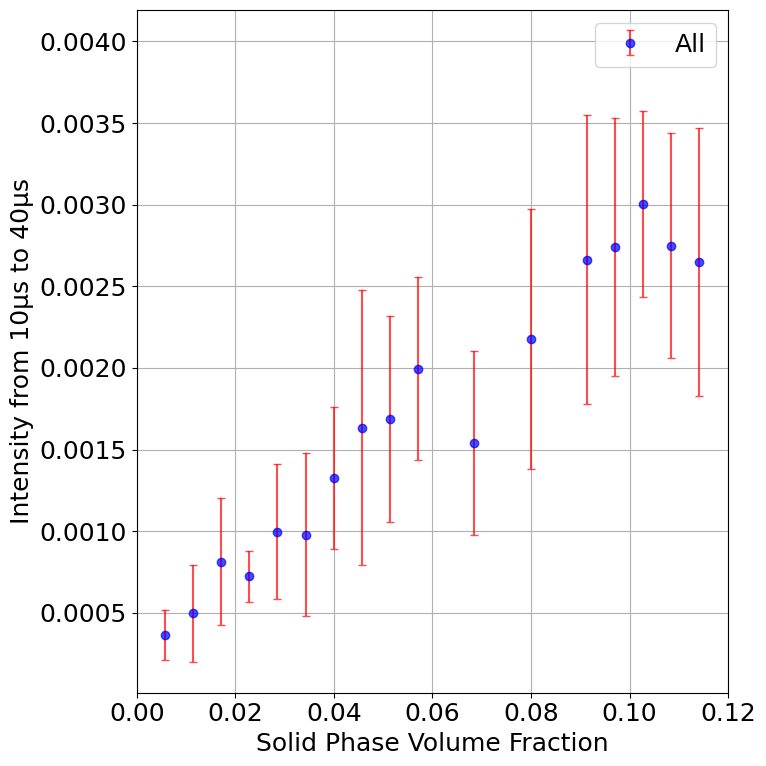

In [ ]:
from src import calculate_gvf_and_signal,npz2png
from src import process_case_and_return_dataset, add_noise_to_dataset
from src import ndarr2npz, hilbert_cuda, filter_signal
import numpy as np
import math
import json
import glob
import os
import torch
import polars as pl
from matplotlib import pyplot as plt
from scipy import integrate

# Define the base directory containing all cases
processed_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed"
output_path = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/dataset"
csv_base_dir ="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal"
save_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/preprocessed"

# Get all case directories (e.g., case5, case6, ...)
case_dirs = sorted([d for d in os.listdir(processed_base_dir) if os.path.isdir(os.path.join(processed_base_dir, d)) and d.startswith("case")])
print(case_dirs)

# case_dirs= ["bubble2.5"]

x_train_list = []
x_error_list = []
t_train_list = []

for case_name in case_dirs:
    if case_name != "case22_mtbr" and case_name!="case22_new" and case_name!="case0":
        base_dir = os.path.join(processed_base_dir, case_name)
        # csv_dir = os.path.join(csv_base_dir, case_name)
        csv_dir = "a"
        print(f"Processing {case_name} in {base_dir}")
        x_tmp, t_tmp = process_case_and_return_dataset(case_name, base_dir,
                                                    csv_dir, output_path,
                                                    rolling_window=False,
                                                    window_size=10, window_stride=10,
                                                    log1p=False,
                                                    if_hilbert=False,
                                                    label_dim=3,
                                                    png_name='raw')
        print(f"x_tmp shape: {x_tmp.shape}, t_tmp shape: {t_tmp.shape}")
        dt = 1/50
        intensity = integrate.simpson(x_tmp[:,500:2000]**2, dx=dt, axis=1)
        x_train_list.append(np.mean(intensity))
        x_error_list.append(np.std(intensity))
        t_train_list.append(np.mean(t_tmp))

x_train_list = np.array(x_train_list)
x_error_list = np.array(x_error_list)
t_train_list = np.array(t_train_list)

plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = 18
plt.errorbar(t_train_list, x_train_list, yerr=x_error_list, fmt='o', color='blue', alpha=0.7, ecolor='red', capsize=3, label='Simulation')
# plt.plot(intensity_target_arr, intensity_mean_arr, 'o', color='blue', alpha=0.7, label='glass ball')
#plt.errorbar(x_valid_stone, y_valid_stone_plot, yerr=yerr_valid_stone_plot, fmt='o', color='orange', alpha=0.7, ecolor='green', capsize=3, label='Stone')
plt.legend()
plt.xlabel("Solid Phase Volume Fraction")
plt.ylabel("Intensity from 10µs to 40µs")
plt.xlim(0, 0.12)
#plt.ylim(0, 0.2)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_base_dir, 'intensity_vs_volume_fraction_3d_new.png'))
plt.show()

2.1550792207700367e-07


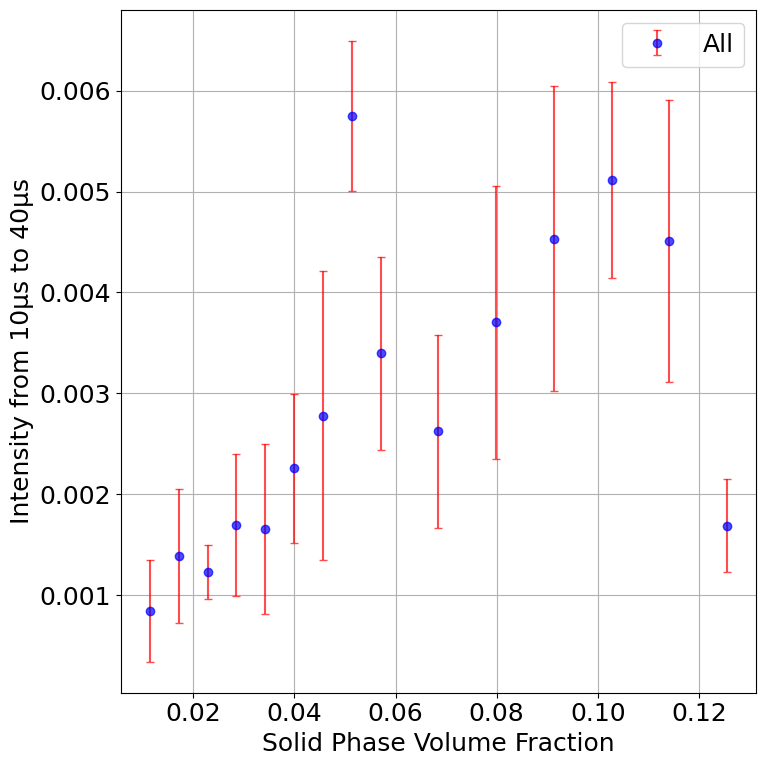

In [ ]:
from src import calculate_gvf_and_signal,npz2png
from src import process_case_and_return_dataset, add_noise_to_dataset
from src import ndarr2npz, hilbert_cuda, filter_signal
import numpy as np
import math
import json
import glob
import os
import torch
import polars as pl
from matplotlib import pyplot as plt
from scipy import integrate

simulation2d_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation2d/dataset"
simulation_dir = "/mnt/sdb/matsubara/airlift/dataset"
save_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/preprocessed"

x_train = np.load(os.path.join(simulation_dir, "x_train.npy"))
t_train = np.load(os.path.join(simulation_dir, "t_train.npy"))
print(np.min(x_train))
dt = 1/(50)

t_train = t_train*128/108

intensity_arr = []
intensity_mean_arr = []
intensity_target_arr = []
num_each_target = []
intensity_error = []

for i in range(len(x_train)):
    x_signal = x_train[i,:]
    intensity = integrate.simpson(x_signal[500:2000]**2, dx=dt)
    if i==0 or t_train[i-1]!=t_train[i]:
        num_each_target.append(1)
        intensity_target_arr.append(t_train[i])
        intensity_arr.append([intensity])
    else:
        num_each_target[-1] += 1
        intensity_arr[-1].append(intensity)
for i in range(len(intensity_arr)):
    cur_arr = intensity_arr[i]
    cur_arr = np.array(cur_arr)
    mean = np.mean(cur_arr)
    err = np.std(cur_arr)
    intensity_mean_arr.append(mean)
    intensity_error.append(err)

intensity_mean_arr = np.array(intensity_mean_arr)
intensity_target_arr = np.array(intensity_target_arr)
num_each_target = np.array(num_each_target)
intensity_error = np.array(intensity_error)

plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = 18
plt.errorbar(intensity_target_arr, intensity_mean_arr, yerr=intensity_error, fmt='o', color='blue', alpha=0.7, ecolor='red', capsize=3, label='All')
# plt.plot(intensity_target_arr, intensity_mean_arr, 'o', color='blue', alpha=0.7, label='glass ball')
#plt.errorbar(x_valid_stone, y_valid_stone_plot, yerr=yerr_valid_stone_plot, fmt='o', color='orange', alpha=0.7, ecolor='green', capsize=3, label='Stone')
plt.legend()
plt.xlabel("Solid Phase Volume Fraction")
plt.ylabel("Intensity from 10µs to 40µs")
#plt.xlim(0, 0.2)
#plt.ylim(0, 0.2)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_base_dir, 'intensity_vs_volume_fraction_3d.png'))
plt.show()

In [ ]:
from src import calculate_gvf_and_signal,npz2png
from src import process_case_and_return_dataset, add_noise_to_dataset
from src import ndarr2npz, hilbert_cuda, filter_signal
import numpy as np
import math
import json
import glob
import os
import torch
import polars as pl
from matplotlib import pyplot as plt
from scipy import integrate,signal

target_variable_path = '/mnt/sdb/matsubara/airlift/target_valiables.csv'
processed_dir = "/mnt/sdb/matsubara/airlift/eval/solid_liquid"
save_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/preprocessed"

# 機械学習用データセット生成(実機)
target_variables = pl.read_csv(
    target_variable_path,encoding="SHIFT_JIS"
)
# If "IDXX" column exists, drop the "NAME" column (to avoid duplication)
if "IDXX" in target_variables.columns:
    target_variables = target_variables.drop("NAME")

# Create a new "NAME" column based on the first and second columns (date and time)
date_col = target_variables.columns[0]
time_col = target_variables.columns[1]
target_variables = target_variables.with_columns(
    (pl.lit("P") + pl.col(date_col).cast(pl.Utf8) + "-" + pl.col(time_col).cast(pl.Utf8)).alias("NAME")
)

# Prepare the list of columns to display (avoid duplicates)
cols_to_show = [col for col in target_variables.columns[2:] if col != "NAME"] + ["NAME"]

# Add a new column "FullPath" that contains the full path to the corresponding processed .npz file
target_variables = target_variables.with_columns(
    (pl.lit(processed_dir + "/") + pl.col("NAME") + pl.lit("_processed.npz")).alias("FullPath")
)

mean_list =[]
var_list =[]
integration_mean_list = []
integration_var_list = []
low_filter_freq = 1e6
high_filter_freq = 10e6
device = "cuda:0"

for row in target_variables.iter_rows(named=True):
    file_path = row["FullPath"]
    if os.path.exists(file_path) and row["気相体積率"]==0 and row["固相体積率"]!=0:
        TDX1 = np.load(file_path)["processed_data"][:,:,0]
        fs = np.load(file_path)["fs"]
        dt = 1/fs*1e6
        sos=signal.butter(16,[1e6,10e6], btype='bandpass', output='sos', fs=fs)
        TDX1 = signal.sosfiltfilt(sos, TDX1, axis=1)
        wall_idx = np.argmax(TDX1>0.5,axis=1)
        integrated_signal = integrate.simpson(TDX1_bandpass[i,500:2000]**2,dx=dt)
        for i in range(TDX1.shape[0]):
            TDX1_bandpass[i,:] /= (np.max(np.abs(TDX1_bandpass[i,:])))
            #TDX1_bandpass[i,:] = np.log1p(TDX1_bandpass[i,:])
            integrated_signal.append(integrate.simpson(TDX1_bandpass[i,500:2000]**2,dx=dt))
            #integrated_signal.append(np.max(np.abs(TDX1_bandpass[i,:])))
        integrated_signal_nd = np.array(integrated_signal)
        integration_mean_list.append(np.mean(integrated_signal_nd))
        integration_var_list.append(np.var(integrated_signal_nd))
        print(f'Calculated var: {np.mean(integrated_signal)}')

# Add the mean and variance as new columns (float or None only)
target_variables = target_variables.with_columns([
    pl.Series("mean", integration_mean_list, dtype=pl.Float64),
    pl.Series("var", integration_var_list, dtype=pl.Float64)
])

cols_to_show = [col for col in target_variables.columns[2:] if col not in ["NAME", "FullPath", "mean", "var"]] + ["NAME", "FullPath", "mean", "var"]

save_path = os.path.join(save_base_dir, "predicted.csv")
target_variables.select(cols_to_show).write_csv(save_path)
print(f"Prediction results saved to {save_path}.")

# Read the CSV file with UTF-8 (with BOM) encoding to prevent character corruption
target_variables = pl.read_csv(
    save_path
)

glass_diameter_col = target_variables["ガラス球直径"]

is_str=np.array([1 if isinstance(v, str) and not v.replace('.','',1).isdigit() else 0 for v in glass_diameter_col.to_numpy()])
# Plot mean (y-axis) vs. solid phase volume fraction (x-axis)
x = target_variables["固相体積率"].to_numpy()
y = target_variables["mean"].to_numpy()
y_stone = y[is_str==1]


yerr = target_variables["var"].to_numpy() ** 0.5
yerr_stone = yerr[is_str == 1]

#  Calculate the correlation coefficient between x and y
# Remove any NaN values before calculation
# x, y, yerr からNaNを除外した有効なデータのみを抽出
def get_valid_data(x, y, yerr):
    """
    Remove NaN values from x, y, and yerr, and return only valid data.
    """
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(yerr)
    x_valid = x[mask]
    y_valid = y[mask]
    yerr_valid = yerr[mask]
    return x_valid, y_valid, yerr_valid

x_valid, y_valid, yerr_valid = get_valid_data(x, y, yerr)

mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(yerr)
x_valid = x[mask]
y_valid = y[mask]
yerr_valid = yerr[mask]

if len(x_valid) > 1:
    corr_coef = np.corrcoef(x_valid, y_valid)[0, 1]
    print(f"Correlation coefficient between x and y: {corr_coef:.4f}")
else:
    print("Not enough valid data to calculate correlation coefficient.")

plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = 18
x_valid_stone, y_valid_stone_plot, yerr_valid_stone_plot = get_valid_data(x[is_str == 1], y_stone, yerr_stone)
#plt.errorbar(x_valid, y_valid, yerr=yerr_valid, fmt='o', color='blue', alpha=0.7, ecolor='red', capsize=3, label='All')
plt.plot(x_valid, y_valid, 'o', color='blue', alpha=0.7, label='glass ball')
#plt.errorbar(x_valid_stone, y_valid_stone_plot, yerr=yerr_valid_stone_plot, fmt='o', color='orange', alpha=0.7, ecolor='green', capsize=3, label='Stone')
plt.plot(x_valid_stone, y_valid_stone_plot, 'o', color='orange', alpha=0.7, label='Stone')
#plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y=x)')
plt.legend()
plt.xlabel("Solid Phase Volume Fraction")
plt.ylabel("Intensity from 10µs to 40µs")
plt.xlim(0, 0.12)
#plt.ylim(0, 0.2)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_base_dir, 'intensity_vs_volume_fraction_noError.png'))
plt.show()



Calculated var: 0.002787899292005417
Calculated var: 0.002800399667938868
Calculated var: 0.0028795002950859246
Calculated var: 0.00289268576076984
Calculated var: 0.0029861277877666144
Calculated var: 0.0030559577107887093
Calculated var: 0.0027829687747713814
Calculated var: 0.0031301646661633445
Calculated var: 0.002459610996347923
Calculated var: 0.0027056560646384242
Calculated var: 0.0024473880588232193
Calculated var: 0.0027255216664886714
Calculated var: 0.0027671501187202093
Calculated var: 0.0024391316710273047
Calculated var: 0.0023772374704708
Calculated var: 0.002545461726313628
Calculated var: 0.00243770541596544
Calculated var: 0.0028681658651783693
Calculated var: 0.0028159635144540114
Calculated var: 0.0028170479333211418
Calculated var: 0.002358860859697044
Calculated var: 0.0024714624369377458
Calculated var: 0.0024250593033297856
Calculated var: 0.002682325522528913
Calculated var: 0.002454633945112179
Calculated var: 0.002596955981461844
Calculated var: 0.002814226

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'float'

## 機械学習用データセット生成(実機)  
次に、変換した`.npz`のファイルに対応する目標変数となる値を`/target_variables.csv`を使って参照し、データセット`x_test.npy` `t_test.npy`を作成していきます。


In [39]:
import polars as pl

# CSVファイルをUTF-8 (BOM付き) で読み込むことで文字化けを防ぐ
target_variables = pl.read_csv(
    '/mnt/sdb/yyamaguchi/psdata2matlab/experiments/target_valiables.csv',
    encoding="SHIFT_JIS"
)
print(target_variables.head())

# 既存の"IDXX"列が重複して作成されるのを防ぐため、まず"IDXX"列が存在すれば削除する
if "IDXX" in target_variables.columns:
    target_variables = target_variables.drop("NAME")

# "IDXX"列を新たに作成
# 1列目・2列目のカラム名を取得
date_col = target_variables.columns[0]
time_col = target_variables.columns[1]
target_variables = target_variables.with_columns(
    (pl.lit("P") + pl.col(date_col).cast(pl.Utf8) + "-" + pl.col(time_col).cast(pl.Utf8)).alias("NAME")
)

# 表示用のカラムリストを作成（重複がないようにする）
cols_to_show = [col for col in target_variables.columns[2:] if col != "NAME"] + ["NAME"]

# 結果を表示
print(target_variables.select(cols_to_show))
from src import mat2npz_exp


import glob

# Get all .mat files in the rawsignal directory
rawsignal_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/experiments/rawsignal"
output_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/experiments/processed"

mat_files = glob.glob(os.path.join(rawsignal_dir, "*.mat"))

# Run mat2npz_exp for each .mat file
for file_path in mat_files:
    print(f"Processing {file_path}")
    mat2npz_exp(
        file_path=file_path,
        output_dir=output_dir,
        start_time=0.1,  #初期の信号は不安定であることが多いため除外
        duration=5.0,
        amplitude_threshold=2,
        window_width=0.1e-3,
        signal_key="TDX1"
    )


shape: (5, 9)
┌──────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ 日付     ┆ 時分 ┆ 固相見かけ ┆ 気相見かけ ┆ … ┆ 固相体積率 ┆ 気相体積率 ┆ 液相体積率 ┆ ガラス球  │
│ ---      ┆ ---  ┆ 流速       ┆ 流速       ┆   ┆ ---        ┆ ---        ┆ ---        ┆ 直径      │
│ i64      ┆ i64  ┆ ---        ┆ ---        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ ---       │
│          ┆      ┆ f64        ┆ f64        ┆   ┆            ┆            ┆            ┆ str       │
╞══════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 20240726 ┆ 1022 ┆ 0.0        ┆ 31.922755  ┆ … ┆ 0.0        ┆ 0.749158   ┆ 0.250842   ┆ -         │
│ 20240726 ┆ 1055 ┆ 0.0        ┆ 32.685636  ┆ … ┆ 0.0        ┆ 0.745521   ┆ 0.254479   ┆ -         │
│ 20240726 ┆ 1113 ┆ 0.0        ┆ 32.048131  ┆ … ┆ 0.0        ┆ 0.7546132  ┆ 0.2453868  ┆ -         │
│ 20240726 ┆ 1122 ┆ 0.0        ┆ 31.968982  ┆ … ┆ 0.0        ┆ 0.742794   ┆ 0.257206   ┆ -         │
│ 20240726 ┆ 13